In [1]:
import os
import sys

sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, RGCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from rdkit import Chem
from rdkit.Chem import AllChem

from src.utils.constants import HOME_DIR, DATA_DIR, LOSS_DIR, CHKPT_DIR, EMBED_DIR

/Users/junhalee/Desktop/CHEM 263/Final Project/drug_toxicology_prediction/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training losses

In [2]:
LLM_losses_path = os.path.join(LOSS_DIR, 'LLM_20241210-035121_epoch_13.csv')
GNN_losses_path = os.path.join(LOSS_DIR, 'rgcn_model_20241210-043903_epoch_199.csv')
fus_losses_path = os.path.join(LOSS_DIR, 'fusion_20241210-044707_epoch_11.csv')

LLM_losses = pd.read_csv(LLM_losses_path)
GNN_losses = pd.read_csv(GNN_losses_path)
fus_losses = pd.read_csv(fus_losses_path)

In [3]:
def graph_losses(losses, title=None, logplot=False):
    train_losses = losses['train_loss']
    val_losses = losses['val_loss']

    if logplot: # y axis is log scale
        plt.semilogy(train_losses, label='train')
        plt.semilogy(val_losses, label='val')
    else:
        plt.plot(train_losses, label='train')
        plt.plot(val_losses, label='val')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    if title:
        plt.title(title)

    plt.legend()
    plt.show()

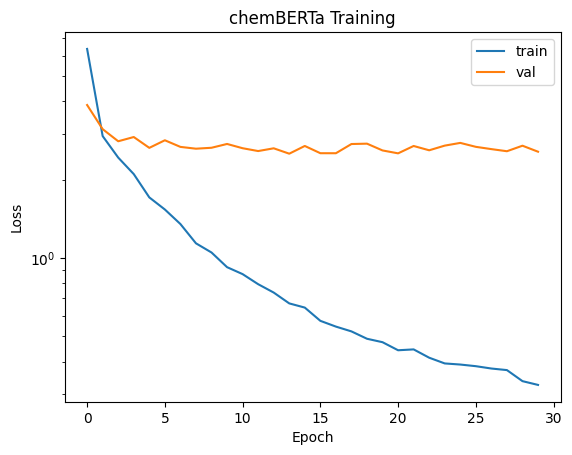

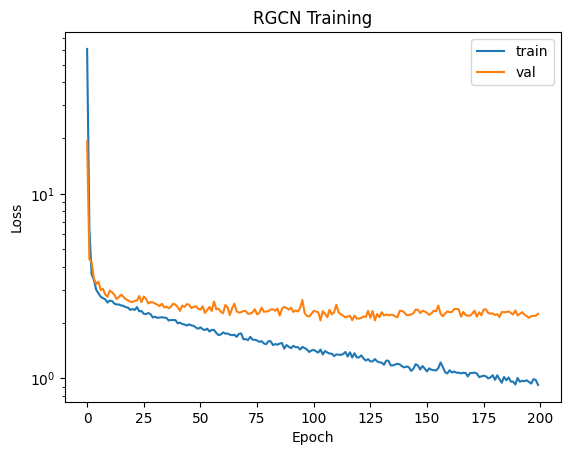

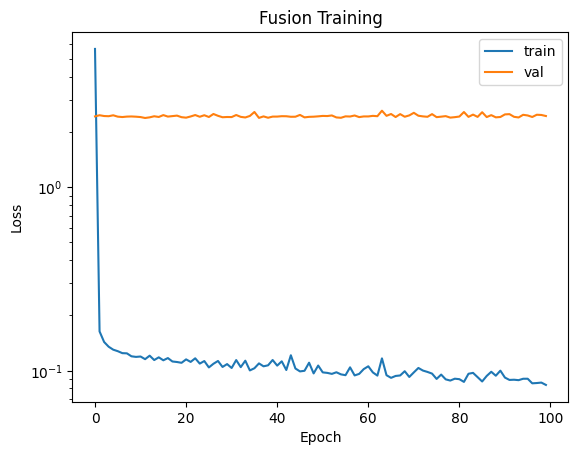

In [4]:
graph_losses(LLM_losses, title='chemBERTa Training', logplot=True)
graph_losses(GNN_losses, title='RGCN Training', logplot=True)
graph_losses(fus_losses, title='Fusion Training', logplot=True)

# Evaluation

In [5]:
from src.utils.data_prep import get_data

data = get_data()
x, y = data['test_x'], data['test_y']

In [6]:
def plot_predictions(y, y_pred, title=None):
    y = np.array(y)

    # Plot a square scatter plot of the true vs predicted values, with a diagonal line
    # representing the line y=x

    # change the size of dots
    plt.scatter(y, y_pred, s=6)

    max_val = max(y.max(), y_pred.max())
    min_val = min(y.min(), y_pred.min())

    plt.plot([min_val, max_val], [min_val, max_val], color='red')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    if title:
        plt.title(title)

    # Calculate R^2 and RMSE using sklearn
    from sklearn.metrics import r2_score, mean_squared_error
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    plt.text(0.1, 0.9, f'R^2: {r2:.2f}', transform=plt.gca().transAxes)
    plt.text(0.1, 0.85, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes)
    
    plt.show()

In [7]:
from transformers import RobertaTokenizer

from src.utils.data_prep import SMILESDataset
from src.model.LLM import RobertaWithEmbeddings

LLM_chkpt_path = os.path.join(CHKPT_DIR, 'LLM_20241210-035121_epoch_13')

tokenizer = RobertaTokenizer.from_pretrained(LLM_chkpt_path)
model = RobertaWithEmbeddings.from_pretrained(LLM_chkpt_path, num_labels=1)  # For regression

dataset = SMILESDataset(x, y, tokenizer)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

y_pred_LLM = []
for batch in dataloader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["label"].to(device)

    # Forward pass
    outputs = model(input_ids=input_ids, attention_mask=attention_mask) # cls_embeddings
    predictions = outputs[0].squeeze()
    y_pred_LLM.append(predictions.detach().cpu().numpy())

y_pred_LLM = np.concatenate(y_pred_LLM)

In [8]:
from src.utils.data_prep import smiles_to_graph_RCGN
from src.model.GCN import RGCNRegressionModel

GNN_chkpt_path = os.path.join(CHKPT_DIR, 'rgcn_model_20241210-043903_epoch_199.pt')

# Convert to PyTorch Geometric Data objects
graph_data = smiles_to_graph_RCGN(x, y)
dataloader = DataLoader(graph_data, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RGCNRegressionModel(input_dim=13, num_edge_types=4).to(device)
model.load_state_dict(torch.load(GNN_chkpt_path))

# Extract embeddings of validation set
y_pred_GNN = []
for batch in dataloader:
    batch = batch.to(device)
    out = model(batch)
    preds = out.squeeze()
    y_pred_GNN.append(preds.detach().cpu().numpy())

y_pred_GNN = np.concatenate(y_pred_GNN)

/var/folders/km/cvdycj097l576cncjdnqjchr0000gn/T/ipykernel_2044/3784076868.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(GNN_chkpt_pa

In [9]:
from src.model.fusion import FusionMLP
from src.utils.data_prep import load_embeddings

fusion_chkpt_path = os.path.join(CHKPT_DIR, 'fusion_20241210-044707_epoch_11.pth')
GNN_embed_path = os.path.join(EMBED_DIR, 'GNN_embeddings_20241210-043903')
LLM_embed_path = os.path.join(EMBED_DIR, 'LLM_embeddings_20241210-035121')

embeddings_data = load_embeddings(GNN_embed_path, LLM_embed_path)
embeddings_x = embeddings_data['test_x']
embeddings_y = embeddings_data['test_y']

model = FusionMLP(input_dim=embeddings_x.shape[1]).to(device)
model.load_state_dict(torch.load(fusion_chkpt_path))

# Evaluate model on embeddings_x (use dataloader)
dataloader = DataLoader(embeddings_x, batch_size=32, shuffle=False)

y_pred_fus = []
for batch in dataloader:
    batch = batch.to(device)
    out = model(batch)
    preds = out.squeeze()
    y_pred_fus.append(preds.detach().cpu().numpy())
y_pred_fus = np.concatenate(y_pred_fus)



/var/folders/km/cvdycj097l576cncjdnqjchr0000gn/T/ipykernel_2044/3343382295.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fusion_chkpt

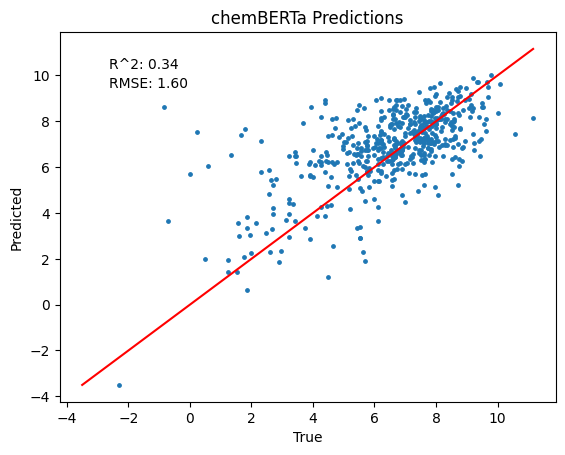

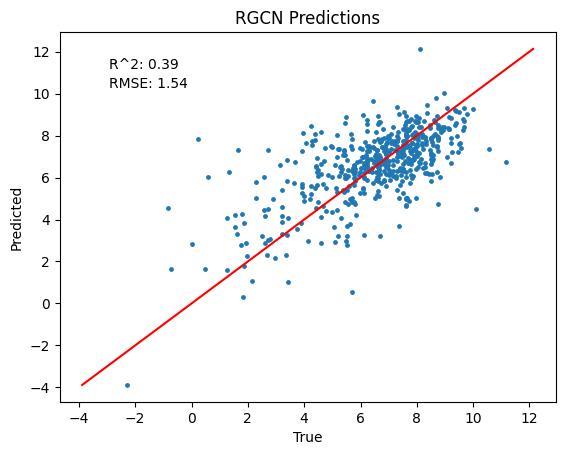

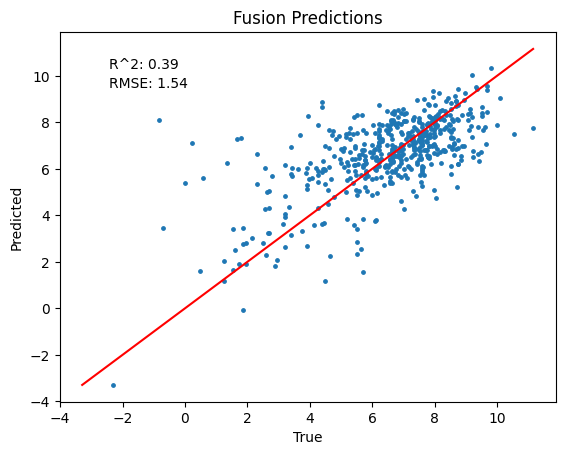

In [10]:
plot_predictions(y, y_pred_LLM, title='chemBERTa Predictions')
plot_predictions(y, y_pred_GNN, title='RGCN Predictions')
plot_predictions(y, y_pred_fus, title='Fusion Predictions')

Mean Squared Error: 2.297141411243774


/var/folders/km/cvdycj097l576cncjdnqjchr0000gn/T/ipykernel_2044/3681537084.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y = np.array(y)


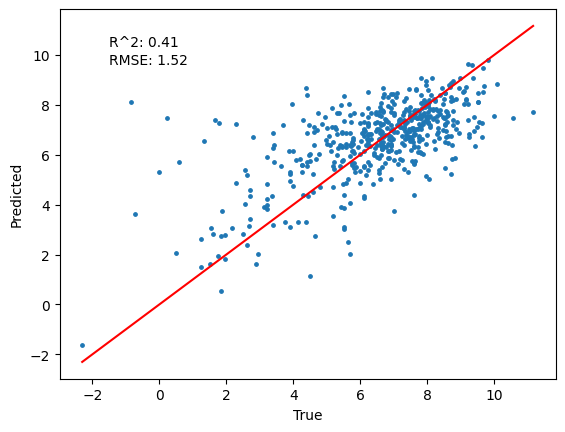

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

train_x, train_y = embeddings_data['train_x'], embeddings_data['train_y']
test_x, test_y = embeddings_data['test_x'], embeddings_data['test_y']
val_x, val_y = embeddings_data['val_x'], embeddings_data['val_y']

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(train_x, train_y)

# Make predictions
y_pred_RF = rf_model.predict(test_x)

# Evaluate the model
mse = mean_squared_error(test_y, y_pred_RF)
print(f'Mean Squared Error: {mse}')

plot_predictions(embeddings_y, y_pred_RF)

/var/folders/km/cvdycj097l576cncjdnqjchr0000gn/T/ipykernel_2044/3681537084.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y = np.array(y)


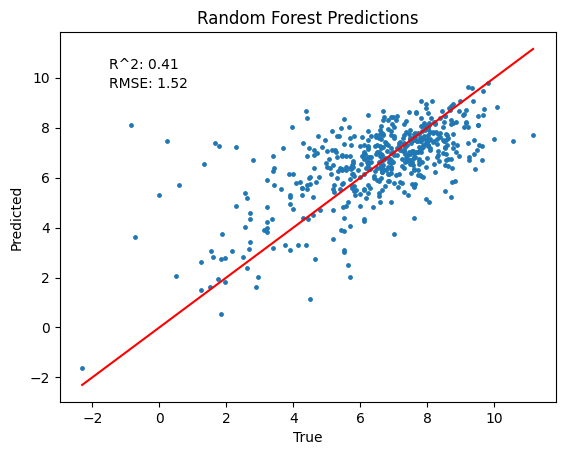

In [15]:
plot_predictions(embeddings_y, y_pred_RF, title='Random Forest Predictions')


In [12]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for the feature importances
features_df = pd.DataFrame({
    'Feature': range(train_x.shape[1]),
    'Importance': feature_importances
})
features_df

,Feature,Importance
0,0,0.000000
1,1,0.000000
2,2,0.000041
3,3,0.000000
4,4,0.000082
...,...,...
1531,1531,0.000113
1532,1532,0.000091
1533,1533,0.000066
1534,1534,0.000190


In [13]:
max(features_df['Importance'])


0.531270636900137

<Figure size 640x480 with 0 Axes>

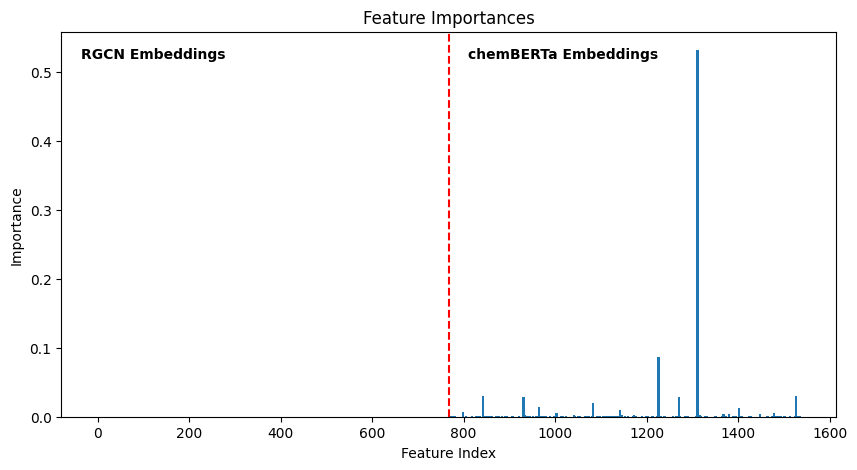

In [39]:
# reset plt
plt.clf()

plt.figure(figsize=(10, 5))
# x axis are the feature indices, y axis are the feature importances

# Make bars thicker
plt.bar(features_df['Feature'], features_df['Importance'], width=5)

# draw a red line at index 768
plt.axvline(768, color='red', linestyle='--')

plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importances') 

# Write 'RGCN Embeddings' in graph in bold at (0.025, 0.93)
plt.text(0.025, 0.93, 'RGCN Embeddings', transform=plt.gca().transAxes, weight='bold')
plt.text(0.525, 0.93, 'chemBERTa Embeddings', transform=plt.gca().transAxes, weight='bold')


plt.show()

<BarContainer object of 1536 artists>

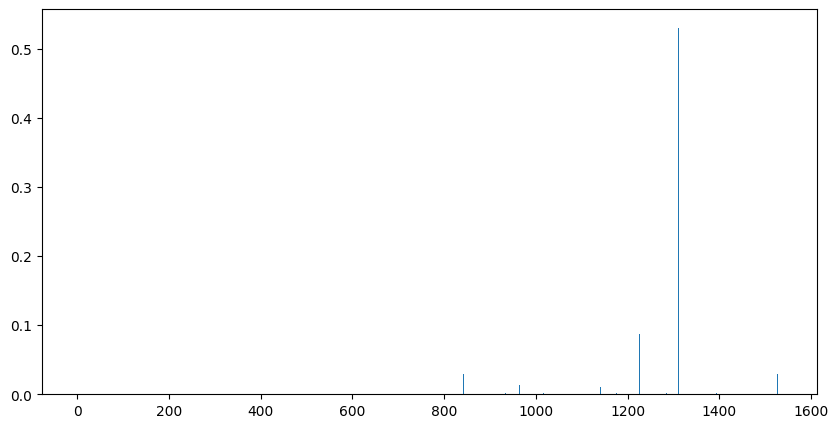

In [28]:
indices = features_df['Feature'].to_numpy()
importances = features_df['Importance'].to_numpy()


# indices are ints
indices = indices.astype(int)

# Create bar plot of index vs importance
# set figure size
plt.figure(figsize=(10, 5))


plt.bar(indices, importances)

ModuleNotFoundError: No module named 'plotly'